In [1]:
import torch

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
path_ws = 'D:/BankClassification/'  

In [3]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = path_ws + 'Train/'
test_dir = path_ws + 'Test/'

# Count images in each class
def count_images_in_class(directory):
    classes = os.listdir(directory)
    class_counts = {}
    
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of images in each class
            class_counts[class_name] = len(os.listdir(class_path))
    
    return class_counts

# Display counts for train and test directories
train_counts = count_images_in_class(train_dir)
test_counts = count_images_in_class(test_dir)

print("Train Class Counts:", train_counts)
print("Test Class Counts:", test_counts)

Train Class Counts: {'Aomsin': 250, 'Bangkok': 250, 'KasikronThai': 250, 'KrungThai': 250, 'SCB': 250}
Test Class Counts: {'Aomsin': 10, 'Bangkok': 10, 'KasikornThai': 10, 'KrungThai': 10, 'SCB': 10}


In [4]:
# Image Augmentation
train_datagen = ImageDataGenerator(
  # rotation_range=90,
  # width_shift_range=0.1,
  # height_shift_range=0.1,
  # shear_range=0.1,
  # zoom_range=0.2,  # ซูมเข้า
  # horizontal_flip=True,
  # vertical_flip=True,
  # brightness_range=[0.9, 1.1],
  # fill_mode='reflect',
  rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet input size
    batch_size=500,
    class_mode='categorical'  # For multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

Found 1250 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [5]:
# Get the number of images per class
train_class_counts = train_generator.class_indices
train_image_counts = {class_name: len([img for img in train_generator.filenames if class_name in img])
                      for class_name in train_class_counts}

test_class_counts = test_generator.class_indices
test_image_counts = {class_name: len([img for img in test_generator.filenames if class_name in img])
                     for class_name in test_class_counts}

# Display the number of images per class
print("Number of training images per class:", train_image_counts)
print("Number of testing images per class:", test_image_counts)

Number of training images per class: {'Aomsin': 250, 'Bangkok': 250, 'KasikronThai': 250, 'KrungThai': 250, 'SCB': 250}
Number of testing images per class: {'Aomsin': 10, 'Bangkok': 10, 'KasikornThai': 10, 'KrungThai': 10, 'SCB': 10}


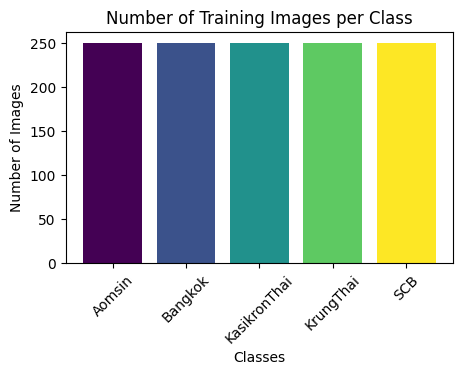

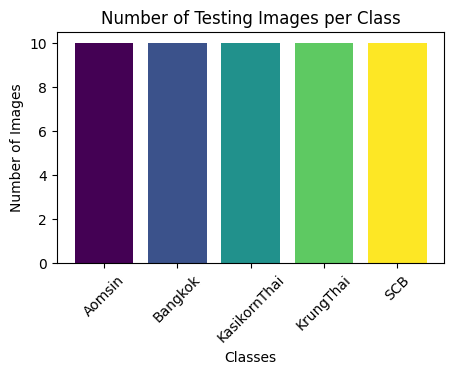

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot image counts with multiple colors
def plot_image_counts(image_counts, title):
    classes = list(image_counts.keys())
    counts = list(image_counts.values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))  # Generate a color for each class

    plt.figure(figsize=(5, 3))
    plt.bar(classes, counts, color=colors)  # Apply multiple colors
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot for training dataset
plot_image_counts(train_image_counts, 'Number of Training Images per Class')

# Plot for testing dataset
plot_image_counts(test_image_counts, 'Number of Testing Images per Class')


### MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_mobilenetv2_model():
    # Load the MobileNetV2 base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # เพิ่ม Batch Normalization
    predictions = Dense(5, activation='softmax')(x)  # 5 classes

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Create the model
optimizer = Adam(learning_rate=0.0001)
model = create_mobilenetv2_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ตรวจสอบโครงสร้างของโมเดล
print(model.summary())


### ResNet50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_resnet_model():
  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(2, activation='softmax')(x)  # 2 classes: FakeSlip RealSlip
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the base model
  for layer in base_model.layers:
      layer.trainable = False

  return model
optimizer = Adam(learning_rate=0.0001)
model = create_resnet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_densenet_model():
    # โหลดโมเดล DenseNet121 พร้อมเวทที่ฝึกบน ImageNet โดยไม่รวมเลเยอร์บนสุด
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # เพิ่มเลเยอร์เฉพาะสำหรับการจำแนก 3 คลาส
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # 2 classes: FakeSlip RealSlip

    # สร้างโมเดลสุดท้าย
    model = Model(inputs=base_model.input, outputs=predictions)

    # ล็อคเลเยอร์ทั้งหมดของ DenseNet121 เพื่อป้องกันการปรับปรุงค่าในเลเยอร์ฐาน
    for layer in base_model.layers:
        layer.trainable = False

    return model

# สร้างและคอมไพล์โมเดล
optimizer = Adam(learning_rate=0.0001)
model = create_densenet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### EfficientNetV2B0

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def create_efficientnet_model():
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # 2 classes: FakeSlip RealSlip
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = create_efficientnet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Train

### --------------------MobileNet--------------------

In [ ]:
%%time
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from datetime import datetime

# ฟังก์ชันคำนวณ n_splits จาก validation_split
def get_n_splits(validation_split):
    if validation_split <= 0 or validation_split >= 1:
        raise ValueError("Validation split must be between 0 and 1 (e.g., 0.2 for 20%)")
    return int(1 / validation_split)

# กำหนดเปอร์เซ็นต์ Validation Split
validation_split = 0.2  # เปลี่ยนเป็น 0.1 สำหรับ 90/10 หรือ 0.25 สำหรับ 75/25
n_splits = get_n_splits(validation_split)

# กำหนดค่าเพื่อใช้ในการทำ Cross-Validation
kf = KFold(n_splits=n_splits, shuffle=True)
print(f"Using {n_splits} splits for {int((1 - validation_split) * 100)}/{int(validation_split * 100)} split")

# ตัวแปรสำหรับเก็บโมเดลที่ดีที่สุด
best_model = None
best_accuracy = 0

# ลิสต์สำหรับเก็บค่าสถิติแต่ละ fold
fold_accuracies = []
fold_losses = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# กำหนด path สำหรับบันทึกโมเดลและกราฟ
model_save_path = 'D:/BankClassification/ModelAfterTrain/MobileNet_2/'
fold_result_path = os.path.join(model_save_path, "FoldResult")
os.makedirs(fold_result_path, exist_ok=True)

# กำหนด batch size
batch_size = 128  # ปรับตามความต้องการ

# ดึงข้อมูลทั้งหมดจาก generator
X_train, y_train = next(train_generator)  # ดึงข้อมูลมาจาก batch หนึ่งของ generator

# สร้าง DataFrame สำหรับบันทึกผลของแต่ละ fold
fold_results = []

# สร้าง EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# เริ่มการวน loop ในแต่ละ fold สำหรับ Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):  # แบ่งข้อมูลออกเป็น fold
    # สร้างโมเดลใหม่ในแต่ละ fold
    model = create_mobilenetv2_model()  # ใส่ฟังก์ชันสร้างโมเดลของคุณที่นี่

    # Compile โมเดลก่อนการฝึก
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # เพิ่ม timestamp ให้กับชื่อไฟล์โมเดล
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # กำหนด callback สำหรับบันทึกโมเดลที่ดีที่สุด
    checkpoint = ModelCheckpoint(
        filepath=f"{model_save_path}best_model_{timestamp}.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # ดึงข้อมูล training และ validation โดยใช้ index ที่แบ่งไว้
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_val_fold = X_train[val_index]
    y_val_fold = y_train[val_index]
    print(f"\nFold {fold + 1}:")
    print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
    print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")

    # เริ่มฝึกโมเดล
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=batch_size,
        epochs=400,
        verbose=1,
        callbacks=[checkpoint, early_stopping]
    )

    # เก็บค่า accuracy และ loss ของ fold ปัจจุบัน
    fold_accuracies.append(history.history['val_accuracy'])
    fold_losses.append(history.history['val_loss'])

    # ทำนายผลลัพธ์สำหรับชุด validation
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val_fold, axis=1)

    # คำนวณค่า precision, recall, และ F1-score
    precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
    recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
    f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

    # เก็บค่า precision, recall, และ F1 ของ fold ปัจจุบัน
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    # บันทึกผลลัพธ์ของแต่ละ epoch ใน fold นี้
    for epoch in range(len(history.history['val_accuracy'])):
        fold_results.append({
            'Fold': fold + 1,
            'Epoch': epoch + 1,
            'Val_Accuracy': history.history['val_accuracy'][epoch],
            'Val_Loss': history.history['val_loss'][epoch],
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1
        })

    # วาดกราฟ accuracy และ loss ของการฝึกฝนในแต่ละ fold
    plt.figure(figsize=(12, 4))

    # กราฟ accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # กราฟ loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # บันทึกกราฟเป็นไฟล์ PNG ในโฟลเดอร์ FoldResult
    graph_path = os.path.join(fold_result_path, f"fold_{fold+1}_graph.png")
    plt.tight_layout()
    plt.savefig(graph_path)
    plt.close()

    # อัปเดตโมเดลที่ดีที่สุดถ้าค่า accuracy ของ fold ปัจจุบันสูงกว่าโมเดลที่ดีที่สุดเดิม
    current_best_accuracy = max(history.history['val_accuracy'])
    if current_best_accuracy > best_accuracy:
        best_accuracy = current_best_accuracy
        best_model = model

# บันทึกโมเดลที่ดีที่สุดเมื่อฝึกครบทุก fold
best_model.save(f"{model_save_path}final_best_model.h5")

# คำนวณค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานสำหรับ accuracy, loss, precision, recall และ F1-score
avg_accuracy = np.mean([np.max(acc) for acc in fold_accuracies])
std_accuracy = np.std([np.max(acc) for acc in fold_accuracies])
avg_loss = np.mean([np.min(loss) for loss in fold_losses])
std_loss = np.std([np.min(loss) for loss in fold_losses])

avg_precision = np.mean(fold_precisions)
std_precision = np.std(fold_precisions)
avg_recall = np.mean(fold_recalls)
std_recall = np.std(fold_recalls)
avg_f1_score = np.mean(fold_f1_scores)
std_f1_score = np.std(fold_f1_scores)

# สร้าง DataFrame สำหรับบันทึกผลสรุป
summary_results_df1 = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1_Score'],
    'Average': [avg_accuracy, avg_loss, avg_precision, avg_recall, avg_f1_score],
    'Standard Deviation': [std_accuracy, std_loss, std_precision, std_recall, std_f1_score]
})

# บันทึกผลสรุปลงในไฟล์ CSV
summary_results_df1.to_csv(f"{model_save_path}test_DenseNet_summary.csv", index=False)

# สร้าง DataFrame สำหรับบันทึกผลแต่ละ fold และบันทึกลงในไฟล์ CSV
fold_results_df = pd.DataFrame(fold_results)
fold_results_df.to_csv(f"{model_save_path}test_DenseNet_folds.csv", index=False)

# แสดงผลสรุป
print(summary_results_df1)


### Train Confusion Matrix

(500, 224, 224, 3)
(500, 5)
16/16 [==============================] - 9s 493ms/step - loss: 0.1178 - accuracy: 1.0000
Test Loss: 0.1178, Test Accuracy: 1.0000
16/16 [==============================] - 10s 559ms/step
Classification Report:
               precision    recall  f1-score   support

      Aomsin       1.00      1.00      1.00        95
     Bangkok       1.00      1.00      1.00        89
KasikornThai       1.00      1.00      1.00       104
   KrungThai       1.00      1.00      1.00       108
         SCB       1.00      1.00      1.00       104

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



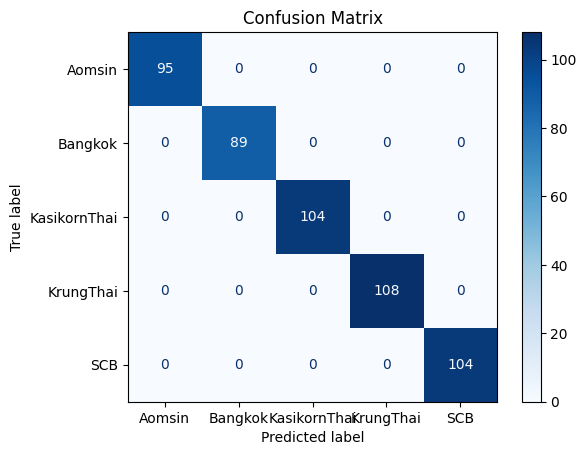

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load the best model for evaluation
#loaded_model = load_model('D:/Endproject/MobileNetV2Model/MobileNetV2Model_Cell28/final_best_model.h5')

#Aucc
# Load the best model for evaluation
loaded_model = load_model('D:/BankClassification/ModelAfterTrain/MobileNet_1/final_best_model.h5')

# Prepare the test data (assuming you have a test generator)
# Replace 'test_generator' with your actual test data generator
X_test, y_test = next(train_generator)  # Fetch one batch of test data
print(X_test.shape)
print(y_test.shape)

# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices
y_true_classes = np.argmax(y_test, axis=1)  # Get the true class indices

# Extract class names from the generator
class_names = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)  # Adjust class names as needed
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Adjust class names as needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

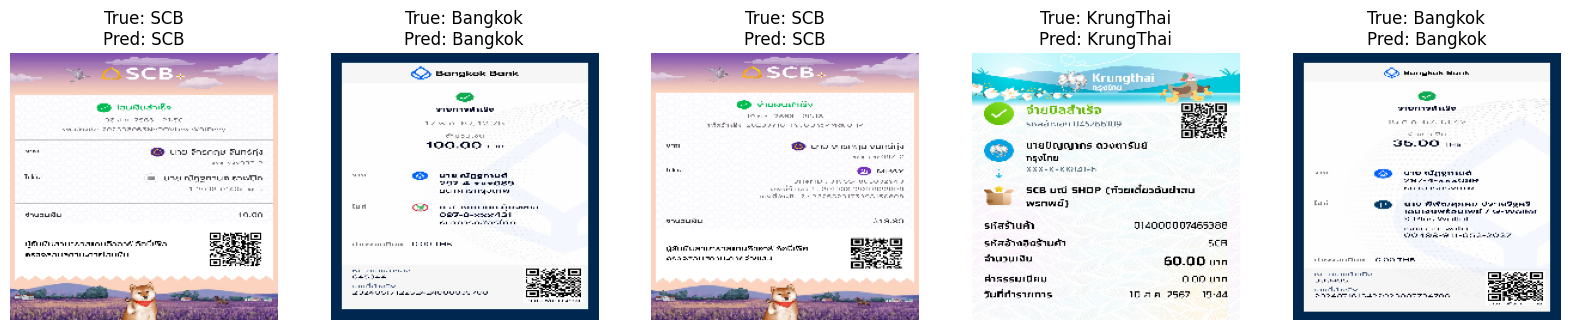

In [8]:
# Identify true predictions
true_indices = np.where(y_pred_classes == y_true_classes)[0]

# Show images of false predictions
def show_false_predictions(X, y_true, y_pred, true_indices, class_names, num_images=5):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(true_indices[:num_images]):  # Show only the first 'num_images' false predictions
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])  # Display the image
        plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')  # Show true and predicted labels
        plt.axis('off')
    plt.show()

# Show false predictions
show_false_predictions(X_test, y_true_classes, y_pred_classes, true_indices, class_names, num_images=5)

### Load Best Model and Compute with Test Set

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size=(224, 224),
  batch_size=128,
  class_mode='categorical',
  shuffle=False  # Important for confusion matrix
)

Found 50 images belonging to 5 classes.


(50, 224, 224, 3)
(50, 5)
2/2 [==============================] - 2s 300ms/step - loss: 0.1246 - accuracy: 1.0000
Test Loss: 0.1246, Test Accuracy: 1.0000
2/2 [==============================] - 1s 279ms/step
Classification Report:
               precision    recall  f1-score   support

      Aomsin       1.00      1.00      1.00        10
     Bangkok       1.00      1.00      1.00        10
KasikornThai       1.00      1.00      1.00        10
   KrungThai       1.00      1.00      1.00        10
         SCB       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



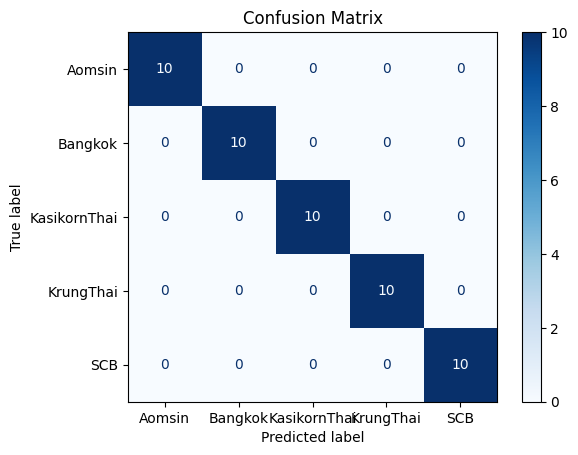

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load the best model for evaluation
#loaded_model = load_model('D:/Endproject/MobileNetV2Model/MobileNetV2Model_Cell28/final_best_model.h5')
#AUCC
loaded_model = load_model('D:/BankClassification/ModelAfterTrain/MobileNet_1/final_best_model.h5') 

# Prepare the test data (assuming you have a test generator)
# Replace 'test_generator' with your actual test data generator
X_test, y_test = next(test_generator)  # Fetch one batch of test data
print(X_test.shape)
print(y_test.shape)

# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices
y_true_classes = np.argmax(y_test, axis=1)  # Get the true class indices

# Extract class names from the generator
class_names = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)  # Adjust class names as needed
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Adjust class names as needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Identify false predictions
false_indices = np.where(y_pred_classes != y_true_classes)[0]

# Show images of false predictions
def show_false_predictions(X, y_true, y_pred, false_indices, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(false_indices[:num_images]):  # Show only the first 'num_images' false predictions
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])  # Display the image
        plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')  # Show true and predicted labels
        plt.axis('off')
    plt.show()

# Show false predictions
show_false_predictions(X_test, y_true_classes, y_pred_classes, false_indices, class_names, num_images=5)

<Figure size 1500x500 with 0 Axes>

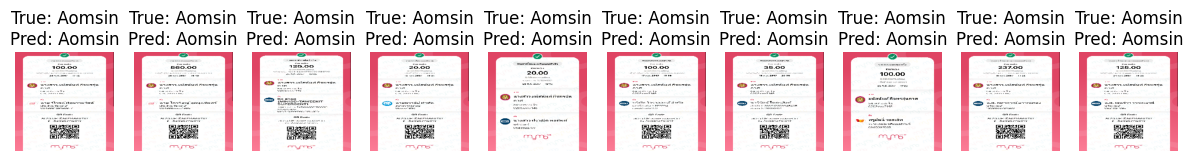

In [12]:
# Identify true predictions
true_indices = np.where(y_pred_classes == y_true_classes)[0]

# Show images of false predictions
def show_false_predictions(X, y_true, y_pred, true_indices, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(true_indices[:num_images]):  # Show only the first 'num_images' false predictions
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])  # Display the image
        plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')  # Show true and predicted labels
        plt.axis('off')
    plt.show()

# Show false predictions
show_false_predictions(X_test, y_true_classes, y_pred_classes, true_indices, class_names, num_images=10)